# Applied Data Science Capstone

***
### IBM DATA SCIENCE PROFESSIONAL CERTIFICATE




### Index

>1. [Gathering commercial property data](#Gathering-commercial-property-data)  
>2. [Using the Foursquare API to locate customers](#Using-the-Foursquare-API-to-locate-customers)
>3. [Employee data collated by the UK Government](#Employee-data-collated-by-the-UK-Government)
>4. [Applying Machine Learning](#Applying-Machine-Learning)

# Importing libraries


In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
from rightmove_webscraper import RightmoveData
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import hdbscan
import descartes
from shapely.geometry import Point, Polygon


#conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


# Gathering commercial property data

In [2]:
#Scraping data from rightmove
url_rentals = "https://www.rightmove.co.uk/commercial-property-to-let/find.html?searchType=RENT&locationIdentifier=REGION%5E87490&insId=2&radius=0.0&displayPropertyType=commercial&minBedrooms=&maxBedrooms=&minPrice=&maxPrice=&areaSizeUnit=sqft&minSize=&maxSize=&maxDaysSinceAdded=&retirement=&sortByPriceDescending=&_includeLetAgreed=on&primaryDisplayPropertyType=&secondaryDisplayPropertyType=&oldDisplayPropertyType=&oldPrimaryDisplayPropertyType=&letType=&letFurnishType=&houseFlatShare="
url_sales = "https://www.rightmove.co.uk/commercial-property-for-sale/find.html?searchType=SALE&locationIdentifier=REGION%5E87490&insId=1&radius=0.0&displayPropertyType=commercial&businessForSale=&minBedrooms=&maxBedrooms=&minPrice=&maxPrice=&areaSizeUnit=sqft&minSize=&maxSize=&partBuyPartRent=&maxDaysSinceAdded=&_includeSSTC=on&sortByPriceDescending=&primaryDisplayPropertyType=&secondaryDisplayPropertyType=&oldDisplayPropertyType=&oldPrimaryDisplayPropertyType=&newHome=&auction=false"
commercial_rentals = RightmoveData(url_rentals)
commercial_sales = RightmoveData(url_sales)

In [3]:
#Building a single dataframe of commercial locations
df1 = commercial_rentals.get_results
df2 = commercial_sales.get_results
df = df1.append(df2, ignore_index=True)

#Dropping columns not relevant to this analysis
df.drop(['url', 'agent_url', 'number_bedrooms', 'search_date'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [41]:
#Checking data
df.head()

Size                    type  \
0  1.001500e+05         Serviced office   
1  9.117512e+09                  Office   
2  1.000400e+09                  Office   
3  5.000034e+10                  Office   
4  3.000000e+05  Commercial development   
5  4.395300e+09                  Office   
6  4.660926e+10  Distribution warehouse   
7  4.255246e+09                  Office   
8  4.975240e+09                  Office   
9  1.115231e+09                  Office   

                                             address postcode  
0           40, Gracechurch Street, London, EC3V 0BT     EC3V  
1          Gateway East, White City, London, W12 7TU      W12  
2                 Republic, Import Building, E14 2BE      E14  
3         Cargo, 25 North Colonnade, London, E14 5HS      E14  
4  S4, Westfield Avenue, London, United Kingdom E...       S4  
5                        1 Angel Court, London, EC2R     EC2R  
6  Stonehill Site, Harbert Road, Edmonton, Enfiel...      N18  
7  Here East, Queen Elizabeth Olympic Park, Londo...      E20  
8  Sixty London Wall, 60 London Wall, London, EC2...     EC2M  
9                   Pancras Square, Kings Cross, N1C      N1C

In [ ]:
lat_T = []
long_T = []
addr_T = []

In [137]:
#Using Geopy to find latitude and longitude co-ordinates for commercial locations

#dfa = df.drop(df.index[0:952]) #Used only when Geopy server times out see below cell to verify placeholder

for i in tqdm(dfa['address']):
    address = str(i.split(', ')[-3:])
    geolocator = Nominatim(user_agent="UK_Explorer")
    location = geolocator.geocode(address)
    time.sleep(0.7)
    try:
        addr_T.append(i)
        lat_T.append(location.latitude)
        long_T.append(location.longitude)
        
    except:
        addr_T.append(i) 
        lat_T.append('nan')
        long_T.append('nan')
        


In [142]:
#Error handling for Geopy server timeouts
print(lat_T[-1],long_T[-1],addr_T[-1])
dfa = df.drop(df.index[0:996])
dfa.head(5)

51.53494655 -0.055157731603773595 45 Vyner Street, London, E2


Size             type  \
996   1003500.0  Serviced office   
997   1003500.0  Serviced office   
998   1003500.0           Office   
999  17003498.0           Office   

                                            address postcode  
996  Eastbourne Terrace, London, Greater London, W2       W2  
997   Old Street Yard, London, Greater London, EC1Y     EC1Y  
998            Durham Street, Vauxhall, London SE11     SE11  
999                     45 Vyner Street, London, E2       E2

In [143]:
# Adding Latitude and Longitude columns as well as removing locations without co-ordinates
df['Latitude'] = lat_T
df['Longitude'] = long_T
df = df[df['Latitude'] != 'nan'].reset_index(drop=True)
 
print(df.count())
df.tail() 

Size         753
type         753
address      753
postcode     753
Latitude     753
Longitude    753
dtype: int64


Size             type  \
748   1003500.0  Serviced office   
749   1003500.0  Serviced office   
750   1003500.0  Serviced office   
751   1003500.0           Office   
752  17003498.0           Office   

                                            address postcode Latitude  \
748                        Park Street, London, W1K      W1K  51.5121   
749  Eastbourne Terrace, London, Greater London, W2       W2  51.4893   
750   Old Street Yard, London, Greater London, EC1Y     EC1Y  51.5235   
751            Durham Street, Vauxhall, London SE11     SE11  51.4864   
752                     45 Vyner Street, London, E2       E2  51.5349   

     Longitude  
748  -0.157574  
749  -0.144055  
750 -0.0899525  
751  -0.119109  
752 -0.0551577

In [144]:
#Saving results to CSV
df.to_csv(r'C:\Users\Claude\rightmove1.csv', index = False)

In [12]:
df_csv2 = pd.read_csv(r'\rightmove1.csv')
address = 'London'
geolocator = Nominatim(user_agent="UK_Explorer")
location = geolocator.geocode(address)
pos_lat = location.latitude
pos_long = location.longitude
df_csv2=df_csv2[df_csv2['Longitude'] > -0.4].dropna()
df_csv2.reset_index(drop=True)
print('File opened')
print(pos_lat,pos_long)


File opened
51.5073219 -0.1276474


In [13]:
map_commercial_buildings = folium.Map(location=[pos_lat, pos_long], zoom_start=10)
for lat,lng in zip(df_csv2['Latitude'], df_csv2['Longitude']):
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        fill=False,
        parse_html=False).add_to(map_commercial_buildings)

In [14]:
map_commercial_buildings

#### Types of properties

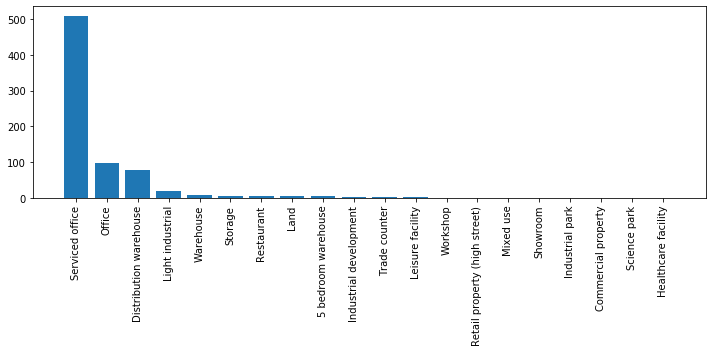

In [307]:
x = df_csv2["type"].unique()
y = df_csv2['type'].value_counts()

f, ax = plt.subplots(figsize=(10,5)) # set the size that you'd like (width, height)
plt.bar(x,y)
plt.xticks(x, rotation=90)
plt.tight_layout()


#### Size distribution

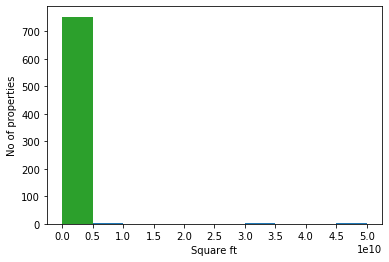

In [304]:
count, bin_edges = np.histogram(df_csv2['Size'])

df_csv2.plot(kind='hist', xticks= bin_edges, legend= False)
plt.ylabel('No of properties')
plt.xlabel('Square ft')

plt.show()

# Using the Foursquare API to locate customers

In [15]:
#Credentials for Foursquare
CLIENT_ID = 'Secret' # your Foursquare ID
CLIENT_SECRET = 'Secret' # your Foursquare Secret
VERSION = '20180604'
radius = 500
LIMIT = 2000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#From the list of categories in the Docs section on Foursquare's website 
#categories = ['52f2ab2ebcbc57f1066b8b1c','4d4b7105d754a06374d81259','50be8ee891d4fa8dcc7199a7', 
#              '4bf58dd8d48988d118951735', '52f2ab2ebcbc57f1066b8b46']

Your credentails:
CLIENT_ID: Secret
CLIENT_SECRET:Secret


### Using Foursquare API with error handling (reaching daily request quota)


In [41]:
#Getting data from the Foursquare API

df_cust = pd.DataFrame()
df_cust_Total = pd.DataFrame()
count = 0
count_calls = 0
cat_id = '52f2ab2ebcbc57f1066b8b46'

# Collecting all the data for specified category from surrounding businesses (potential customers)
for lat,lng in zip(df_csv2['Latitude'], df_csv2['Longitude']):
    count_calls =+1
    url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}"
    .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, cat_id, radius)
    results = requests.get(url).json()
    time.sleep(0.5)
    customers = results['response']['venues']
    df_cust = json_normalize(customers)
    df_cust_Total = df_cust_Total.append(df_cust, ignore_index=True)
    df_cust_Total.sort_values("id", inplace = True)
    df_cust_Total.drop_duplicates(subset ="id", keep = False, inplace = True)

# Save to CSV for later use   
df_cust_Total.to_csv(r'\cust1.csv', index = False)        
           

KeyError: 'venues'

In [146]:
# Data collected at various times (my daily call limits were reached so had to spread collection over days)
df_cust1 = pd.read_csv(r'\cust1.csv')
df_cust2 = pd.read_csv(r'\cust2.csv')
df_cust3 = pd.read_csv(r'\cust3.csv')
df_cust4 = pd.read_csv(r'\cust4.csv')
df_cust5 = pd.read_csv(r'\cust5.csv')
df_cust6 = pd.read_csv(r'\cust6.csv')
df_cust7 = pd.read_csv(r'\cust7.csv')
df_cust8 = pd.read_csv(r'\cust8.csv')
converted_coords = pd.read_csv(r'\adjusted_coords.csv')
print("All csv's opened!, Yay!")

dfs = [df_cust1, df_cust2, df_cust3, df_cust4, df_cust5,
       df_cust6, df_cust7, df_cust8]



All csv's opened!, Yay!


In [147]:
#creating a customer dataframe to which all the data will be appended to
df_cust_all = pd.concat(dfs, ignore_index=True, sort=True)
df_cust_all.drop_duplicates(subset ="id", keep = False, inplace = True)
df_cust_all.reset_index(drop=True, inplace=True)
df_cust_all.head()

categories  delivery.id  \
0  [{'id': '4bf58dd8d48988d16d941735', 'name': 'C...          NaN   
1  [{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...          NaN   
2  [{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...          NaN   
3  [{'id': '4bf58dd8d48988d155941735', 'name': 'G...          NaN   
4  [{'id': '52e81612bcbc57f1066b7a06', 'name': 'I...          NaN   

  delivery.provider.icon.name delivery.provider.icon.prefix  \
0                         NaN                           NaN   
1                         NaN                           NaN   
2                         NaN                           NaN   
3                         NaN                           NaN   
4                         NaN                           NaN   

  delivery.provider.icon.sizes delivery.provider.name delivery.url  hasPerk  \
0                          NaN                    NaN          NaN    False   
1                          NaN                    NaN          NaN    False   
2                          NaN                    NaN          NaN    False   
3                          NaN                    NaN          NaN    False   
4                          NaN                    NaN          NaN    False   

                         id           location.address  ...  \
0  4ac518b9f964a520bda120e3           25 Lonsdale Road  ...   
1  4ac518bef964a5200ea320e3  153 Concert Hall Approach  ...   
2  4ac518c0f964a520aba320e3         157A Commercial St  ...   
3  4ac518c3f964a52030a420e3                 36 The Cut  ...   
4  4ac518c3f964a5203ca420e3            21-22 Maiden Ln  ...   

                           location.formattedAddress  \
0  ['25 Lonsdale Road', 'London', 'Greater London...   
1  ['153 Concert Hall Approach', 'London', 'Great...   
2  ['157A Commercial St', 'London', 'Greater Lond...   
3  ['36 The Cut (Waterloo)', 'London', 'Greater L...   
4  ['21-22 Maiden Ln', 'London', 'Greater London'...   

                             location.labeledLatLngs location.lat  \
0  [{'label': 'display', 'lat': 51.53734194664702...    51.537342   
1  [{'label': 'display', 'lat': 51.50507257189726...    51.505073   
2  [{'label': 'display', 'lat': 51.52147765393434...    51.521478   
3  [{'label': 'display', 'lat': 51.50338372931985...    51.503384   
4  [{'label': 'display', 'lat': 51.51041034814778...    51.510410   

  location.lng  location.neighborhood location.postalCode  location.state  \
0    -0.203672                    NaN             NW6 6RA  Greater London   
1    -0.115948                    NaN             SE1 8XU  Greater London   
2    -0.075617                    NaN              E1 6BJ  Greater London   
3    -0.106439                    NaN             SE1 8LP  Greater London   
4    -0.123653                    NaN            WC2E 7NA  Greater London   

                     name    referralId venuePage.id  
0            Organic Cafe  v-1585160801          NaN  
1            The Archduke  v-1585160686          NaN  
2  Hawksmoor Spitalfields  v-1585160814          NaN  
3       The Anchor & Hope  v-1585160743          NaN  
4             Porterhouse  v-1585160694          NaN  

[5 rows x 25 columns]

In [149]:
#Removing all irrelevant columns
df_cust_all.drop(['delivery.id', 'delivery.provider.icon.name', 'delivery.provider.icon.prefix', 'delivery.provider.icon.sizes',
                  'delivery.provider.name', 'delivery.url', 'hasPerk', 'location.labeledLatLngs', 'location.neighborhood', 'referralId', 'venuePage.id',
                 'location.crossStreet', 'location.distance', 'location.formattedAddress'], axis=1, inplace=True)
df_cust_all.reset_index(drop=True, inplace=True)
df_cust_all.head()

categories  \
0  [{'id': '4bf58dd8d48988d16d941735', 'name': 'C...   
1  [{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...   
2  [{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...   
3  [{'id': '4bf58dd8d48988d155941735', 'name': 'G...   
4  [{'id': '52e81612bcbc57f1066b7a06', 'name': 'I...   

                         id           location.address location.cc  \
0  4ac518b9f964a520bda120e3           25 Lonsdale Road          GB   
1  4ac518bef964a5200ea320e3  153 Concert Hall Approach          GB   
2  4ac518c0f964a520aba320e3         157A Commercial St          GB   
3  4ac518c3f964a52030a420e3                 36 The Cut          GB   
4  4ac518c3f964a5203ca420e3            21-22 Maiden Ln          GB   

  location.city location.country  location.lat  location.lng  \
0        London   United Kingdom     51.537342     -0.203672   
1        London   United Kingdom     51.505073     -0.115948   
2        London   United Kingdom     51.521478     -0.075617   
3        London   United Kingdom     51.503384     -0.106439   
4        London   United Kingdom     51.510410     -0.123653   

  location.postalCode  location.state                    name  
0             NW6 6RA  Greater London            Organic Cafe  
1             SE1 8XU  Greater London            The Archduke  
2              E1 6BJ  Greater London  Hawksmoor Spitalfields  
3             SE1 8LP  Greater London       The Anchor & Hope  
4            WC2E 7NA  Greater London             Porterhouse

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories'].split(', ')[1].split(': ')[1]
    except:
        None
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list

In [17]:
# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
nearby_venues = df_cust_all.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.tail()

name     categories  \
2774                                            Iceland  'Supermarket'   
2775                                  Sainsbury's Local  'Supermarket'   
2776                                          As Nature  'Supermarket'   
2777  Marks & Spencer LONDON BRIDGE WESTERN ARCADE A...  'Supermarket'   
2778                          Yoyo Oriental Supermarket  'Supermarket'   

            lat       lng  
2774  51.574972 -0.013516  
2775  51.600257 -0.068156  
2776  51.514494 -0.161885  
2777  51.504658 -0.085885  
2778  51.514289 -0.069860

In [18]:
#Dropping coordinates which are out of bounds
nearby_venues=nearby_venues[nearby_venues['lng'] > -0.4].dropna()
nearby_venues.reset_index(drop=True)


name     categories  \
0                                          Organic Cafe         'Café'   
1                                          The Archduke   'Steakhouse'   
2                                Hawksmoor Spitalfields   'Steakhouse'   
3                                     The Anchor & Hope    'Gastropub'   
4                                           Porterhouse    'Irish Pub'   
...                                                 ...            ...   
2729                                            Iceland  'Supermarket'   
2730                                  Sainsbury's Local  'Supermarket'   
2731                                          As Nature  'Supermarket'   
2732  Marks & Spencer LONDON BRIDGE WESTERN ARCADE A...  'Supermarket'   
2733                          Yoyo Oriental Supermarket  'Supermarket'   

            lat       lng  
0     51.537342 -0.203672  
1     51.505073 -0.115948  
2     51.521478 -0.075617  
3     51.503384 -0.106439  
4     51.510410 -0.123653  
...         ...       ...  
2729  51.574972 -0.013516  
2730  51.600257 -0.068156  
2731  51.514494 -0.161885  
2732  51.504658 -0.085885  
2733  51.514289 -0.069860  

[2734 rows x 4 columns]

In [45]:
#Saving results to CSV
nearby_venues.to_csv(r'\convert.csv', index = False)

In [19]:
#Extracting the top 15 stats from the potential customers dataframe
print('Top 15 customer categories of',nearby_venues['categories'].count(),'entries')
print(nearby_venues['categories'].value_counts().head(15))


Top 15 customer categories of 2734 entries
'Grocery Store'           460
'Coffee Shop'             263
'Café'                    258
'Restaurant'               89
'Italian Restaurant'       85
'Pizza Place'              78
'Indian Restaurant'        75
'Bakery'                   74
'Fast Food Restaurant'     72
'Chinese Restaurant'       68
'Market'                   65
'Burger Joint'             56
'Sandwich Place'           52
'Supermarket'              42
'Pub'                      35
Name: categories, dtype: int64


In [51]:
#Visualising the locations of potential customers
map_customer_buildings = folium.Map(location=[pos_lat, pos_long], zoom_start=10)
for lat,lng in zip(nearby_venues['lat'], nearby_venues['lng']):
    folium.CircleMarker(
        [lat, lng],
        color='red',
        radius=2,
        fill=False,
        parse_html=False).add_to(map_customer_buildings)

map_customer_buildings

# Employee data collated by the UK Government

In [22]:
# Opening the excel spreadsheet into a dataframe
df_emp = pd.read_excel('Employees1.xlsx', header=0) 
df_emp = df_emp.drop(df_emp.index[0])
df_emp.drop(['2005 LLW: £6.70','2005 LLW: £6.70.1','2006 LLW: £7.05','2007 LLW: £7.20','2008 LLW: £7.45','2009 LLW: £7.60',
       '2010 LLW: £7.85','2011 LLW: £8.30','2012 LLW: £8.55','2013 LLW: £8.80','2014 LLW: £9.15','2015 LLW: £9.40',
       '2016 LLW: £9.75'], axis=1, inplace=True)
df_cust_all.reset_index(drop=True, inplace=True)
df_emp.head()

Code             Area name  2017 LLW: £10.20
1  E09000001        City of London           29000.0
2  E09000002  Barking and Dagenham           13000.0
3  E09000003                Barnet           33000.0
4  E09000004                Bexley           24000.0
5  E09000005                 Brent           35000.0

In [143]:
#Opening the shape file and creating GEOdataframe
fp = "London cloropleth/London-wards-2018_ESRI/London_Ward_CityMerged.shp"
map_df = gpd.read_file(fp)
map_df.drop(['GSS_CODE', 'HECTARES', 'NONLD_AREA'], axis=1, inplace=True)
map_df.reset_index(drop=True, inplace=True)
map_df.tail()

NAME                               DISTRICT  LAGSSCODE  \
628       Whalebone                   Barking and Dagenham  E09000002   
629       Eastbrook                   Barking and Dagenham  E09000002   
630  Chadwell Heath                   Barking and Dagenham  E09000002   
631        Parsloes                   Barking and Dagenham  E09000002   
632  Castle Baynard  City and County of the City of London  E09000001   

                                              geometry  
628  POLYGON ((549410.698 187450.702, 549391.199 18...  
629  POLYGON ((549991.497 184928.504, 549988.899 18...  
630  POLYGON ((548874.200 188496.303, 548843.199 18...  
631  POLYGON ((547381.597 185753.598, 547377.499 18...  
632  POLYGON ((531361.303 180690.997, 531313.201 18...

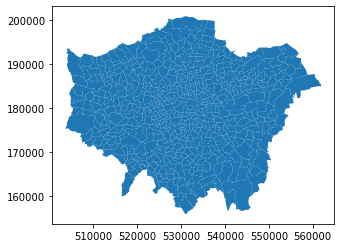

In [25]:
#Plotting the geometry
map_df.plot()

In [27]:
#Combining the income data and GEOdataframe
merged_empl = map_df.set_index('LAGSSCODE').join(df_emp.set_index('Code'))
merged_empl.fillna(0, inplace=True)

merged_empl.head()

NAME                               DISTRICT  \
E09000001  Castle Baynard  City and County of the City of London   
E09000002       Gascoigne                   Barking and Dagenham   
E09000002          Thames                   Barking and Dagenham   
E09000002           River                   Barking and Dagenham   
E09000002         Village                   Barking and Dagenham   

                                                    geometry  \
E09000001  POLYGON ((531361.303 180690.997, 531313.201 18...   
E09000002  POLYGON ((543574.498 183951.404, 543571.702 18...   
E09000002  POLYGON ((545802.000 181308.800, 545798.397 18...   
E09000002  POLYGON ((549072.799 183605.103, 549074.102 18...   
E09000002  POLYGON ((549049.301 184708.297, 549070.202 18...   

                      Area name  2017 LLW: £10.20  
E09000001        City of London           29000.0  
E09000002  Barking and Dagenham           13000.0  
E09000002  Barking and Dagenham           13000.0  
E09000002  Barking and Dagenham           13000.0  
E09000002  Barking and Dagenham           13000.0

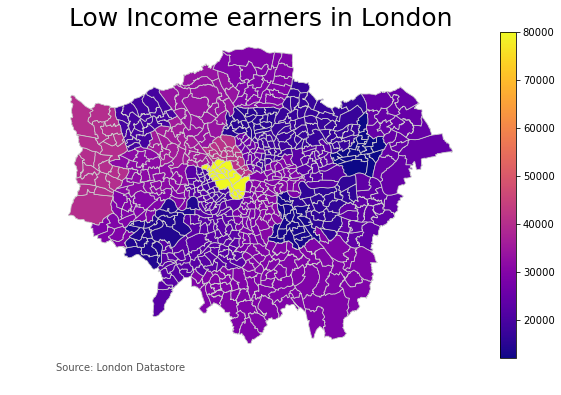

In [28]:
# set a variable that will call whatever column we want to visualise on the map
variable = '2017 LLW: £10.20'

# set the range for the choropleth
vmin, vmax = 12000, 80000

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

# create map
merged_empl.plot(column=variable, cmap='plasma', linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Low Income earners in London', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: London Datastore',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)


# Applying Machine Learning

#### Applying the DBScan Algorithm

In [60]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
import branca
import branca.colormap as cm

In [115]:
Clus_dataSet = StandardScaler().fit_transform(nearby_venues[['lng','lat']])
epsilon = 0.03
minimumSamples = 3
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(Clus_dataSet)
labels = db.labels_
nearby_venues['clust_db'] = labels
nearby_venues.head()

name    categories        lat       lng  clust_db
0            Organic Cafe        'Café'  51.537342 -0.203672         0
1            The Archduke  'Steakhouse'  51.505073 -0.115948         1
2  Hawksmoor Spitalfields  'Steakhouse'  51.521478 -0.075617         4
3       The Anchor & Hope   'Gastropub'  51.503384 -0.106439         2
4             Porterhouse   'Irish Pub'  51.510410 -0.123653         3

In [116]:
# First, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([ True,  True, False, ...,  True,  True,  True])

In [117]:
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

226

In [118]:
# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)

# Create colors for the clusters.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

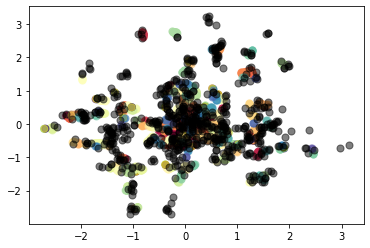

In [119]:
# Plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = Clus_dataSet[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

    # Plot the outliers
    xy_outliers = Clus_dataSet[class_member_mask & ~core_samples_mask]
    plt.scatter(xy_outliers[:, 0], xy_outliers[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

In [120]:
df_split_outliers = nearby_venues['clust_db'] < 0
df_clusters = nearby_venues['clust_db'] > -1
df_split_outliers = nearby_venues[df_split_outliers]
df_split_outliers.reset_index(drop=True, inplace=True)
df_clusters = nearby_venues[df_clusters]
df_clusters.reset_index(drop=True, inplace=True)

In [121]:
df_clusters.max

name     categories  \
2090                   Marks & Spencer Food On The Move  'Supermarket'   
2091                                            Iceland  'Supermarket'   
2092                                          As Nature  'Supermarket'   
2093  Marks & Spencer LONDON BRIDGE WESTERN ARCADE A...  'Supermarket'   
2094                          Yoyo Oriental Supermarket  'Supermarket'   

            lat       lng  clust_db  
2090  51.514659 -0.154369       121  
2091  51.574972 -0.013516       219  
2092  51.514494 -0.161885       101  
2093  51.504658 -0.085885        46  
2094  51.514289 -0.069860        80

In [138]:
#Creating a colourmap to differiantiate the various clusters
colormap = cm.LinearColormap(colors=['red','lightblue'], index=None, vmin=0, vmax=df_clusters['clust_db'].max())

#Plotting the clusters of potential customers with a distance of 0.3 on a folium map
DBscan_results = folium.Map(location=[pos_lat, pos_long], zoom_start=10)

lat = list(df_clusters.lat)
lon = list(df_clusters.lng)
clust = list(df_clusters.clust_db)


for loc, c in zip(zip(lat, lon), clust):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color=colormap(c),
        #fill_opacity=0.7
    ).add_to(DBscan_results)
    
lat_out = list(df_split_outliers.lat)
lon_out = list(df_split_outliers.lng)
clust_out = list(df_split_outliers.clust_db)
    
for loc, c in zip(zip(lat_out, lon_out), clust_out):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color='grey',
        fill_opacity=0.7
    ).add_to(DBscan_results)
    

    
DBscan_results.add_child(colormap)

display(DBscan_results)

In [192]:
#Dropping the outliers and adding the potential commercial properties with reference labels

#Creating a colourmap to differiantiate the various clusters
colormap = cm.LinearColormap(colors=['red','lightblue'], index=None, vmin=0, vmax=df_clusters['clust_db'].max())

#Plotting the clusters of potential customers with a distance of 0.3 on a folium map
DBscan_results = folium.Map(location=[pos_lat, pos_long], zoom_start=10)

lat = list(df_clusters.lat)
lon = list(df_clusters.lng)
clust = list(df_clusters.clust_db)


for loc, c in zip(zip(lat, lon), clust):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color=colormap(c),
        #fill_opacity=0.7
    ).add_to(DBscan_results)
    
lat_out = list(df_split_outliers.lat)
lon_out = list(df_split_outliers.lng)
clust_out = list(df_split_outliers.clust_db)

#Outliers turned off
#for loc, c in zip(zip(lat_out, lon_out), clust_out):
#    folium.Circle(
#        location=loc,
#        radius=10,
#        fill=True,
#        color='Blue',
#        fill_opacity=0.7
#    ).add_to(DBscan_results)
    
for lat,lng,lbl in zip(df_csv2['Latitude'], df_csv2['Longitude'], df_csv2['address']):
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        fill=True,
        color='Blue',
        fill_opacity=0.7,
        label =[lat, lng, lbl]
    ).add_to(DBscan_results)
    

    
DBscan_results.add_child(colormap)

display(DBscan_results)